In [1]:
# 1) Mean/Median Age (Age_Days) - Descriptive Statistics Mean/IQR
# 2) Mean/Median Weight (WT_KGS) - Descriptive Statistics Mean/IQR
# 3) Gender distribution (GENDER) - significant differences? - One Way Chi Squre
# 4) Most common Breeds (BREED) - One Way Chi Squre
# 5) Most common shunts (SHUNT) - One Way Chi Squre
# 6) Most common portal vein origin (PORTAL_V) - One Way Chi Squre
# 7) Most common systemic vein insertion (SYSTEM_V) - One Way Chi Squre
# 8) Most common contributing vessels (CONTRB_V) - One Way Chi Squre
# 9) PP score distribution (PP_Score) - One Way Chi Squre and Descriptive Statistics Mean/IQR (age, wt, and pps_n are set as continuous exploratory)

# Cross tab frequencies and ANOVA
# HOSPITAL COMPARISONS (HOSPITAL):
# 10) Do the above values differ AMONG HOSPITALS (HOSPITAL) - Two Way Chi Squre (Comprehensive pairwise comparisons reveals)

# Cross tab frequencies and ANOVA
# COUNTRY COMPARISONS (COUNTRY):
# 11) Do the above values differ AMONG COUNTRIES (COUNTRY)  - Two Way Chi Squre (Comprehensive pairwise comparisons reveals)

# Cross tab frequencies and ANOVA
# BREED COMPARISONS (BREED): [5 MOST COMMON BREEDS]
# 12) What is Gender distribution (GENDER) comparison among 5 most common breeds (BREED)? - Two Way Chi Squre (Comprehensive pairwise comparisons reveals)
# 13) What is Age distribution (Age_Days) comparison among 5 most common breeds (BREED)? - Sub ANOVA limited to breeds 61, 38, 53, 35, 47
# 14) What are 5 most common Shunts  (SHUNT) comparison among 5 most common breeds (BREED)? - Two Way Chi Squre (Comprehensive pairwise comparisons reveals)
# 15) What is PP Score (PP_Score) comparison among 5 most common breeds (BREED)? # Probably best looked at categorically with two-way
# comprehensive chi-square for contingency table first time (Comprehensive pairwise comparisons reveals)


# Regression and ANOVA
# AGE COMPARISONS (Age_Days):
# 16) Does AGE (Age_Days) correlate with Breed (BREED) - RQ 13 handles this with age as DV and Breed (Top 5) as IV with 5 class levels fo breed
# 17) Does AGE (Age_Days) correlate with PP Score (PP_Score) - Standard ANOVA but similar issue with shunt type having a lot of cats, see 18
# 18) Does AGE (Age_Days) correlate with Shunt (SHUNT) - There are 44 different shunt types (shunt type is not ordinal) and age is continuous. 
#  An ANOVA would 
# not yield meaningful results iwth the 44 goups giving a mean age for pairise comparisons.  We could contribute collapsing shunt and 
# bucketing age.


# SHUNT COMPARISONS (SHUNT) ANOVA:
# 19) Does Shunt (SHUNT) correlate with Weight (WT_KGS)    [Above and below mean/median?] - see 20
# 20) Does Shunt (SHUNT) correlate with PP Score (PP_Score) There are 44 different shunt types (non-ordinal) and 11 (with one missing) pp Score.  
# This could be a 
# either a huge cross tab or a difficlt it interpret ANOVA.   Need to define DV/IV an consider collpasing (top 5?) Shunt Type. See 17 and 18

# Breed ANOVA and Cross Tab
# These (21, 22, 23) are all caegorical with multiple and in most cases non-ordinal categorization making inelgible for regression and 
# multiple categories difficult to interpret with thin data classes for ANOVA.  Suggest first round (Comprehensive pairwise comparisons reveals)
# 21) Does PV origin (PORTAL_V) correlate with breed (BREED) # Cross Tab Frequency - Two Way Chi Square
# 22) Does systemic v insertion (SYSTEM_V) correlate with breed (BREED) # Cross Tab Frequency - Two Way Chi Square
# 23) Do contributing vessels (CONTRB_V) correlate with breed (BREED) # Cross Tab Frequency - Two Way Chi Square

In [2]:
from tabulate import tabulate
import os, saspy, itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
today = datetime.today().strftime("%Y-%m-%d")
now = datetime.now()

#Stats Import
from scipy.stats import wilcoxon 
# from numpy.random import seed
# from numpy.random import math

import pingouin as pg
from pingouin import pairwise_ttests, pairwise_tukey, pairwise_gameshowell
import statsmodels.stats.multicomp as mc
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import scipy.stats as stats
import statsmodels.api as sm
from bioinfokit.analys import stat
from statsmodels.formula.api import ols

sys.path.append(os.path.join(sys.path[0],'C:\Junk\lamb_consulting'))
sys.path.append(os.path.join(sys.path[0],'U:\lamb_consulting'))


# import cox, means, regressions

from lamb_consulting import *

from lamb_consulting.means import means_desc, means_desc_class, aov
from lamb_consulting.freqs import freqs, chi_contingency, chi_oneway
from lamb_consulting.export import export_to_Excel
# from lamb_consulting.regressions import ols, regression_plot
from lamb_consulting.cox import cox
from lamb_consulting.kaplan_meier import km,km_plots


def freqme(ds,var1):
    f=ds[var1].value_counts(dropna=False)
    p=ds[var1].value_counts(normalize=True)
    df=pd.concat({f,p}, axis=1, keys=['frequency', 'percent'])
    df["cumfrequency"] = df["frequency"].cumsum()
    df["cumpercent"] = df["percent"].cumsum()
    return df

In [3]:
print(os.getcwd())
# tpath = "C:/Junk/Weisse/EHPSS/"
tpath = "U:/Fox/Weisse/EHPSS/"
fn="EHPSS20221207"

extension='.xlsx'
file = tpath+fn+extension

df_in = pd.read_excel((file), sheet_name='Data')




# Filter out age lt 90d 
df = df_in.loc[(df_in['age_d']>=90)]
df['contrb_v'].fillna(method='ffill')
df['wt_kg'].fillna(method='ffill')


def male_n(row):
    if row["gender"] == 1 or row["gender"] == 2:
        return 1
    elif row["gender"] == 3 or row["gender"] == 4:
        return 0
    else:
        return -1


def male_c(row):
    if row["gender_1"] == 'MC' or row["gender_1"] == 'MI' or row["gender_1"] == 'NM' or row["gender_1"] == 'MN' or row["gender_1"] == 'ME' or row["gender_1"] == 'M':
        return "M"
    elif row["gender_1"] == 'FS' or row["gender_1"] == 'FI' or row["gender_1"] == 'FE': 
        return "F"
    else:
        return "error"


df['male_n'] = df.apply(male_n,axis=1)
df['male_c'] = df.apply(male_c,axis=1)

cont = ['age_d', 'wt_kg', 'pps_n']
cat = ['male_n', 'breed_n', 'shunt_ty', 'portal_v', 'system_v', 'contrb_v', 'hospital', 'country', 'pps_n']
cat_nopps = ['male_n', 'breed_n', 'shunt_ty', 'portal_v', 'system_v', 'contrb_v', 'hospital', 'country']


# cont_describe = "age_d wt_kg pps_n"
# cat_describe = "male_c breed_nc shunt_ty portal_v system_v contrb_v hospital country pps_n"


# print(df["gender_1"].value_counts())
# print(df["gender"].value_counts())

# print(df["male_c"].value_counts())
# print(df["male_n"].value_counts())


u:\Fox\Weisse\EHPSS


C:\Users\Ken\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Ken\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# One Way Frequency

In [4]:

my_list = cat.copy()
my_list.remove("breed_n")
my_list += ['breed_n']

cat_one = pd.DataFrame()
for i in my_list:
    cat_one = cat_one.append(chi_oneway(df,i))


cat_one


,table,var_level,frequency,percent,cumfrequency,cumpercent,p_value
0,Table male_n,0.0,561,0.529745,561,0.529745,0.052875
1,Table male_n,1.0,498,0.470255,1059,1.000000,0.052875
0,Table shunt_ty,1.0,292,0.275732,292,0.275732,0.000000
1,Table shunt_ty,2.0,201,0.189802,493,0.465534,0.000000
2,Table shunt_ty,3.0,159,0.150142,652,0.615675,0.000000
...,...,...,...,...,...,...,...
57,Table breed_n,7.0,1,0.000944,1055,0.996223,0.000000
58,Table breed_n,65.0,1,0.000944,1056,0.997167,0.000000
59,Table breed_n,28.0,1,0.000944,1057,0.998111,0.000000
60,Table breed_n,10.0,1,0.000944,1058,0.999056,0.000000


# Create Top 5 Breed dataset based of of the one-way Chi-Squre Output

In [5]:
# breed_t5_list = [61, 38, 53, 35, 47]
breed_t5_list = df['breed_n'].value_counts().keys()[0:5].sort_values(ascending=False).tolist()
breed_mask = (df['breed_n'].isin(breed_t5_list)) 
breed_t5 = df.loc[breed_mask]
print(breed_t5_list)
print(df.shape)
print(breed_t5.shape)

[61.0, 53.0, 47.0, 38.0, 35.0]
(1059, 28)
(596, 28)


# Two Way Frequency

In [6]:

iter_list = list(itertools.combinations(cat, 2))
iter_list

print(len(iter_list))
cross_cat = pd.DataFrame()

my_len = (len(iter_list))
for i in range(0, len(iter_list)):
    # print(i)
    res = [iter_list[i]]
    # print(res)
    # print(type(res))
    a = res[0]
    # print(type(a))
    v1,v2 = a
    # print(v1)
    # print(v2)
    # type(x)
    cross_tmp = chi_contingency(df,v1,v2,"1","chi_cont")
    cross_cat = cross_cat.append(cross_tmp)

type(cross_cat)

cross_cat.head()


36


,r_q_n,analysis,research_q,Table,Frequency,Percent,Missing,iv1,iv2
0,1,chi_cont,1,Table male_n * breed_n,2,0.191571,.,0,1.0
1,1,chi_cont,1,Table male_n * breed_n,0,0.000000,.,0,2.0
2,1,chi_cont,1,Table male_n * breed_n,0,0.000000,.,0,3.0
3,1,chi_cont,1,Table male_n * breed_n,2,0.191571,.,0,4.0
4,1,chi_cont,1,Table male_n * breed_n,4,0.383142,.,0,5.0


# Descriptive Means first Overall then by Class

In [7]:

# df = df.astype({'pps_n': 'int64', 'contrb_v': 'int64'})
# cat_c = ['male_c', 'breed_nc', 'shunt_ty', 'portal_v', 'system_v', 'contrb_v', 'hospital', 'country', 'pps_n']
# pps_n          1078 non-null   float64

m_desc = pd.DataFrame()
m_class = pd.DataFrame()

for i in cont:
        desc_tmp = means_desc(df, i)
        m_desc = m_desc.append(desc_tmp)

print(m_desc)

for i in cat:
    for j in cont:
        desc_class_tmp = means_desc_class(df,j, i)
        m_class = m_class.append(desc_class_tmp)

print(m_class)



      ds  nmiss       n         mean  median          std    min      max  \
0  age_d      0  1059.0  1456.997356  733.00  3702.599491  93.00  41319.0   
0  wt_kg     14  1045.0     4.841608    4.45     2.623598   0.83     12.0   
0  pps_n      4  1055.0     3.358294    4.00     1.624809   1.00      5.0   

     p25      p75  
0  311.5  1760.50  
0    2.7     6.35  
0    2.0     5.00  
        ds  level    var  nmiss      n         mean  median          std  \
0   male_n    1.0  age_d    0.0  498.0  1378.391566   704.5  3148.919269   
1   male_n    0.0  age_d    0.0  561.0  1526.775758   749.0  4134.020716   
0   male_n    1.0  wt_kg    4.0  494.0     5.245101     4.8     2.715480   
1   male_n    0.0  wt_kg   10.0  551.0     4.479855     4.0     2.485703   
0   male_n    1.0  pps_n    2.0  496.0     3.471774     4.0     1.591394   
..     ...    ...    ...    ...    ...          ...     ...          ...   
1    pps_n    5.0  pps_n    0.0  408.0     5.000000     5.0     0.000000   
2  

# Diffs with Tukeys Adjustment

In [33]:
anova_df = df.loc[:,['wt_kg','shunt_ty','male_n']].dropna()

test = stat()
# test.tukey_hsd(df=df, res_var='wt_kg', xfac_var='shunt_ty', anova_model='wt_kg ~ C(shunt_ty)')
test.tukey_hsd(df=anova_df, res_var='wt_kg', xfac_var=['shunt_ty','male_n'], anova_model='wt_kg ~ C(shunt_ty) + C(male_n)')
ts = test.tukey_summary
ts


# test.anova_stat(df=df, res_var='wt_kg', anova_model='wt_kg ~ C(shunt_ty)')
# test.anova_summary




# This works but with dropna()
# test=pairwise_tukeyhsd(anova_df["wt_kg"], anova_df['shunt_ty'])
# print(test)
# This Still kicks out 1-4
# test2=pairwise_tukeyhsd(df["wt_kg"], df['shunt_ty'])
# print(test2)

# sns.boxplot(x="shunt_ty_c", y="wt_kg", data=df, palette="Set3") 







# This gives everything but one-way ANOVA only
# anova_df.pairwise_tukey(dv='wt_kg', between=['shunt_ty']).round(3)






# THis just gives overall f-test
# model = ols('wt_kg ~ C(shunt_ty)', data=anova_df).fit()
# sm.stats.anova_lm(model, type=2)

# # This works but still drops lower classes unless dropna() is used
# mc = MultiComparison(df['wt_kg'], df['shunt_ty'])
# Working but must be dropna()
# mc = MultiComparison(anova_df['wt_kg'], anova_df['shunt_ty'])
# mcresult=mc.tukeyhsd(0.05)
# mcresult.summary()







# ANOVA results with combinations of 2 groups:
# formula = 'wt_kg ~ C(shunt_ty_c) + C(male_c) + C(shunt_ty_c):C(male_c)'
# lm = ols(formula, anova_df).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)


# anova_df['combination'] = anova_df['shunt_ty_c'] + " / " + anova_df['male_c'] 

# # perform multiple pairwise comparison (Tukey HSD)
# m_comp = pairwise_tukeyhsd(endog=anova_df['wt_kg'], groups=anova_df['combination'], alpha=0.05)

# # coerce the tukeyhsd table to a DataFrame
# tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])

# group1_comp =tukey_data.loc[tukey_data.reject == True].groupby('group1').reject.count()
# group2_comp = tukey_data.loc[tukey_data.reject == True].groupby('group2').reject.count()
# tukey_data = pd.concat([group1_comp, group2_comp], axis=1)

# tukey_data = tukey_data.fillna(0)
# tukey_data.columns = ['reject1', 'reject2']
# tukey_data['total_sum'] = tukey_data.reject1 + tukey_data.reject2

# # just show the top 20 results
# tukey_data.sort_values('total_sum',ascending=False).head(20)





C:\Users\Ken\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\bioinfokit\analys.py:886: RuntimeWarning: divide by zero encountered in true_divide
  mse_factor = np.sqrt(np.divide(mse, group1_count) + np.divide(mse, group2_count))
C:\Users\Ken\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\bioinfokit\analys.py:894: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, group2_count)))))
C:\Users\Ken\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\bioinfokit\analys.py:897: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, group2_count)))))
C:\Users\Ken\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\bioinfokit\analys.py:893: RuntimeWarning: divide by zero e


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(9, 1)","(9, 0)",1.970000,-4.899244,8.839244,1.728840,0.900000
1,"(9, 1)","(1, 1)",1.092295,-3.858233,6.042822,1.330104,0.900000
2,"(9, 1)","(1, 0)",1.534828,-3.399200,6.468856,1.875234,0.900000
3,"(9, 1)","(4, 1)",1.578928,-3.451273,6.609128,1.892232,0.900000
4,"(9, 1)","(4, 0)",2.433825,-2.632026,7.499675,2.896238,0.900000
...,...,...,...,...,...,...,...
3823,"(39, 1)","(43, 1)",NaN,NaN,NaN,NaN,0.556613
3824,"(39, 1)","(43, 0)",NaN,NaN,NaN,NaN,0.556613
3825,"(39, 0)","(43, 1)",0.000000,-inf,inf,0.000000,0.900000
3826,"(39, 0)","(43, 0)",8.100000,-7.260097,23.460097,3.178985,0.900000


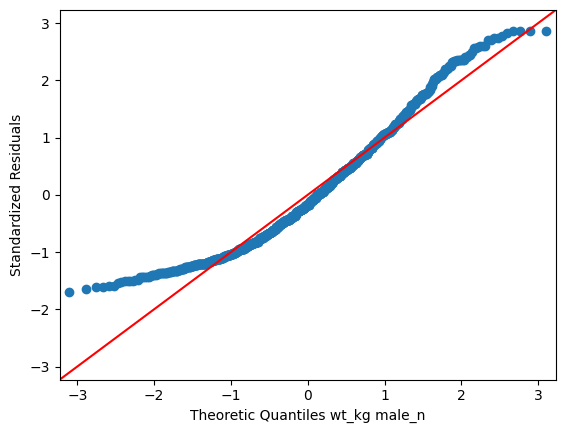

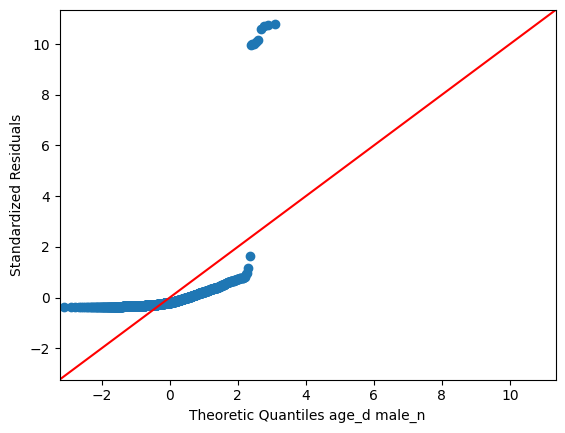

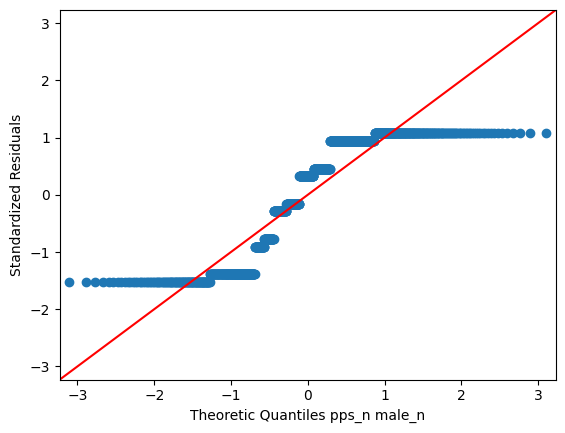

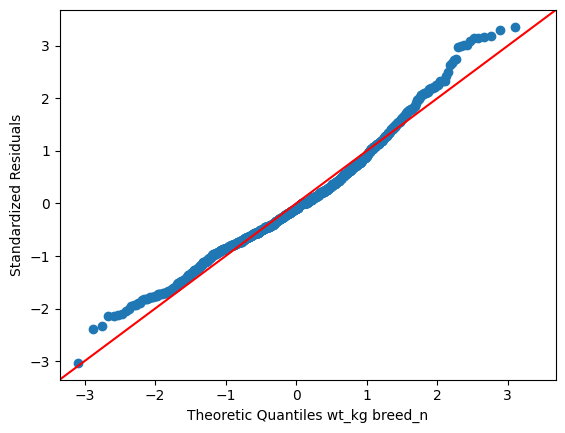

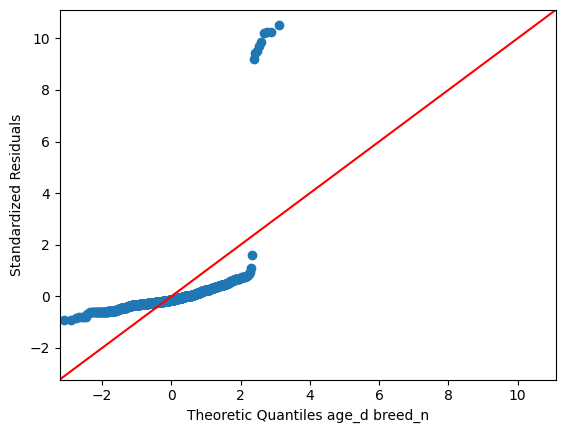

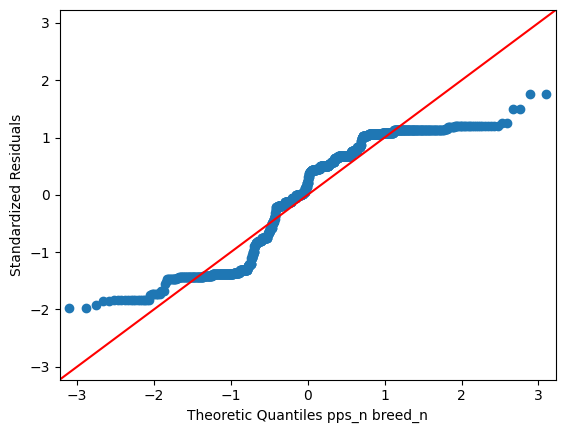

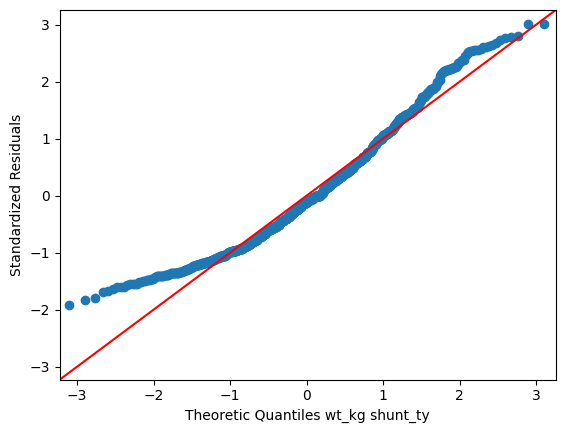

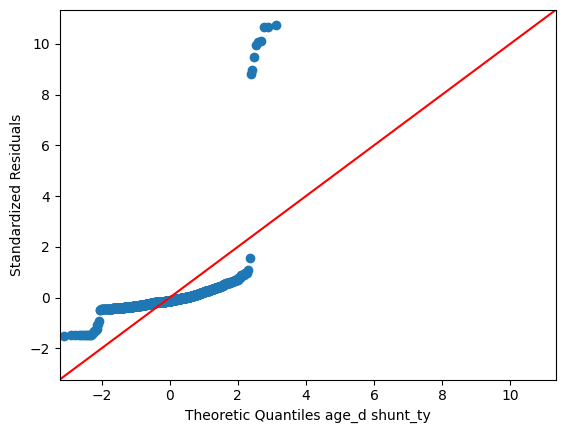

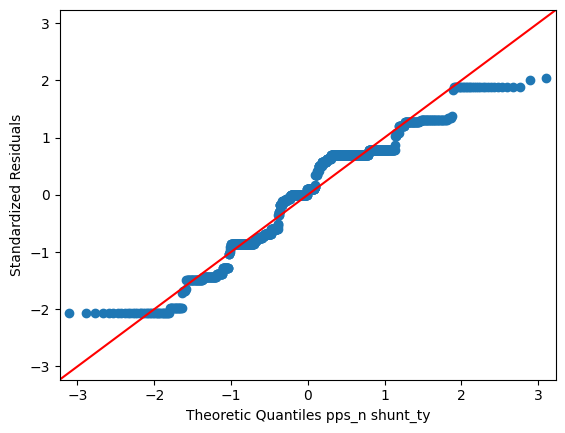

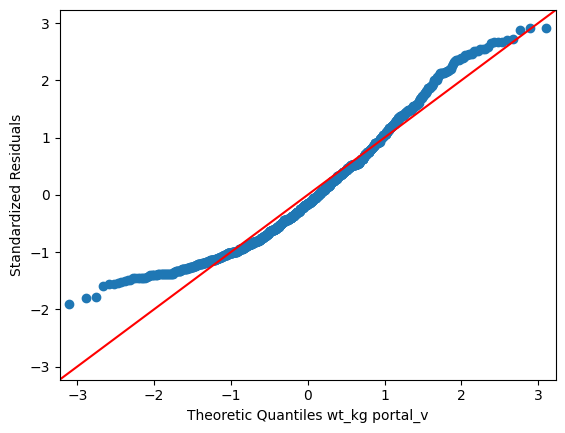

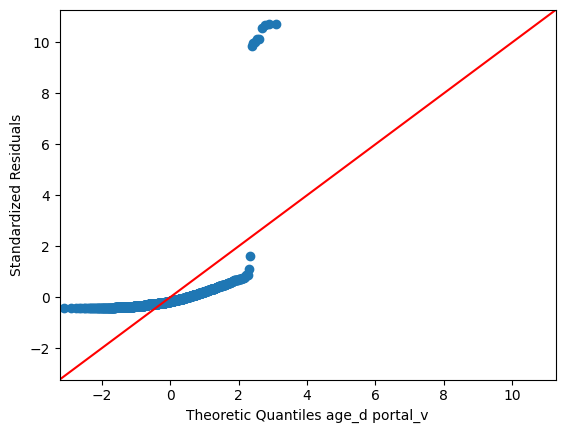

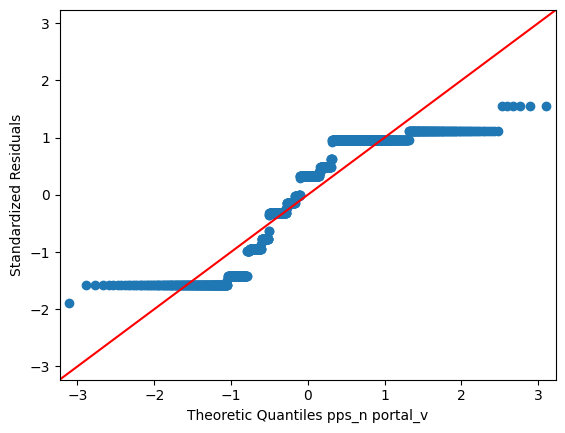

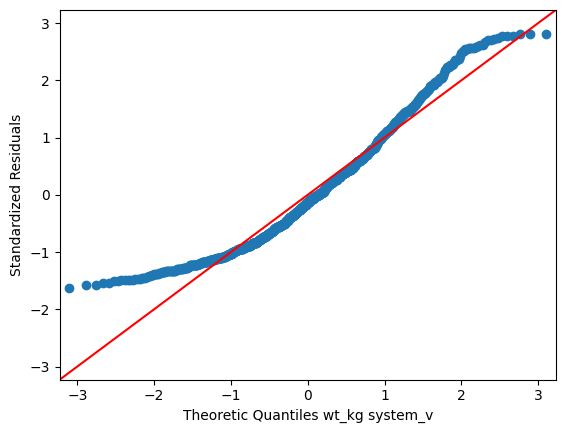

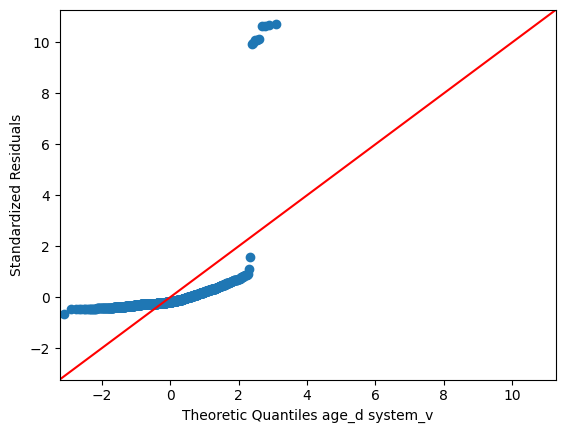

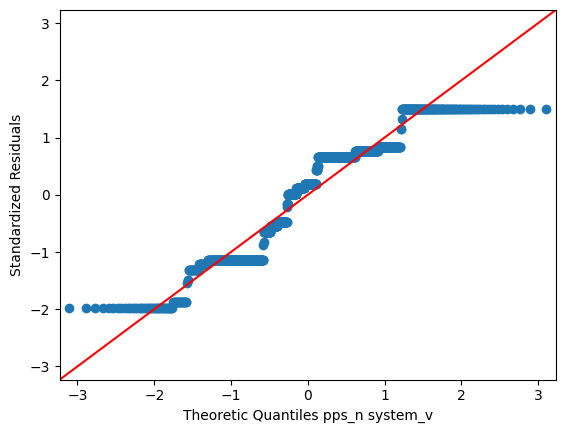

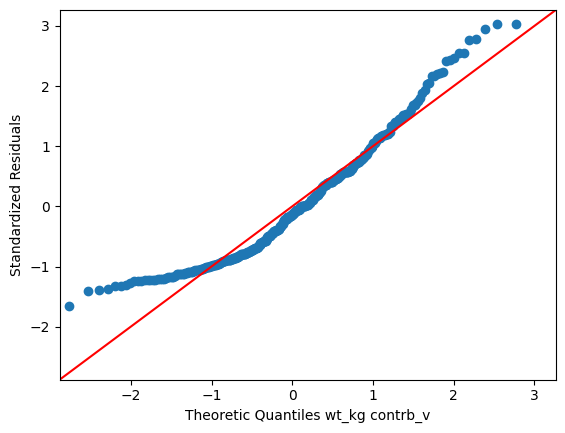

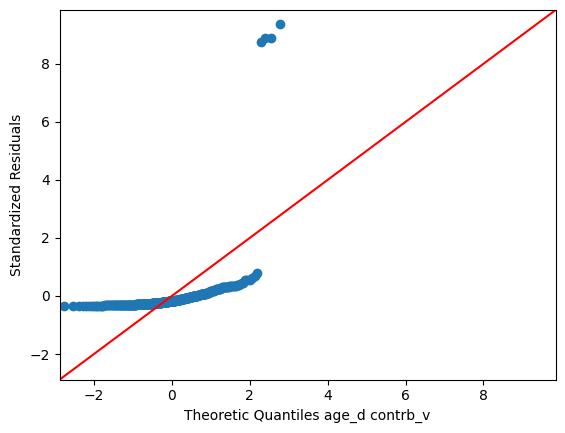

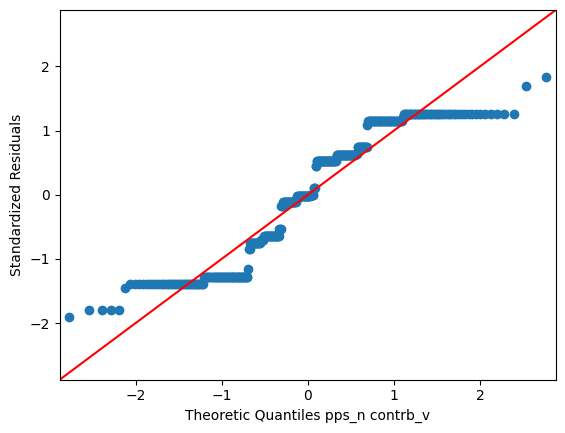

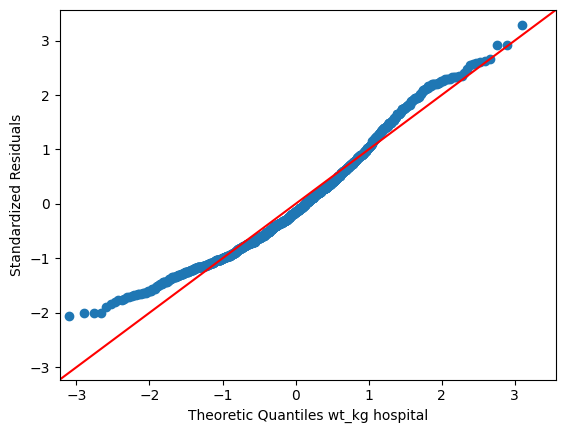

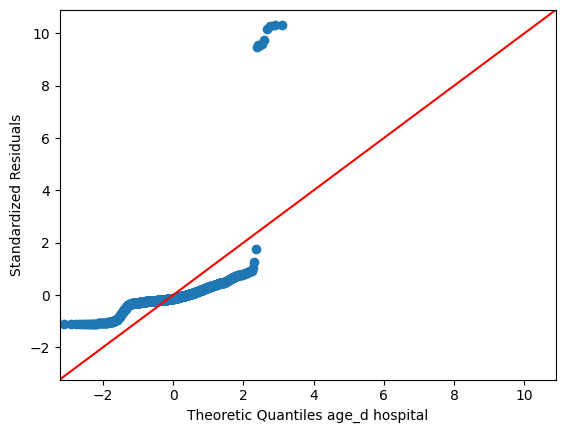

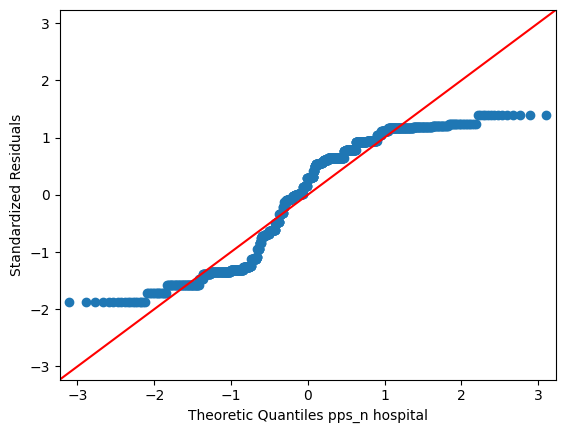

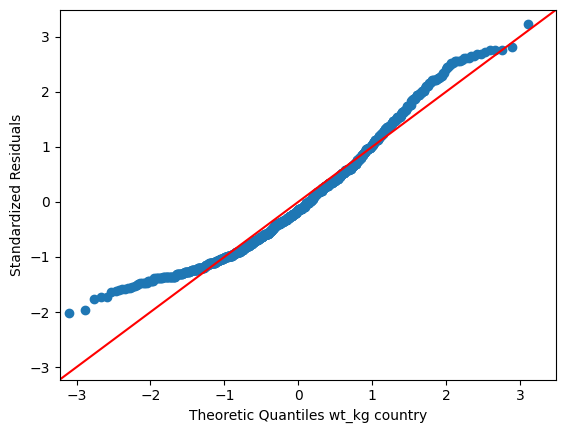

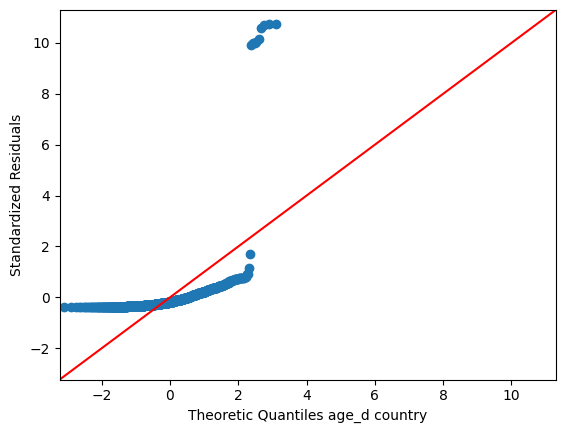

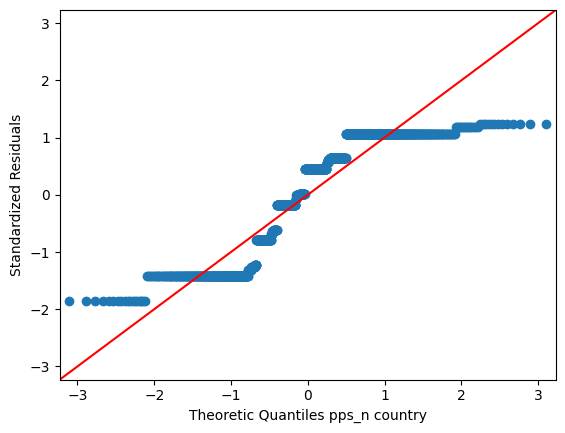

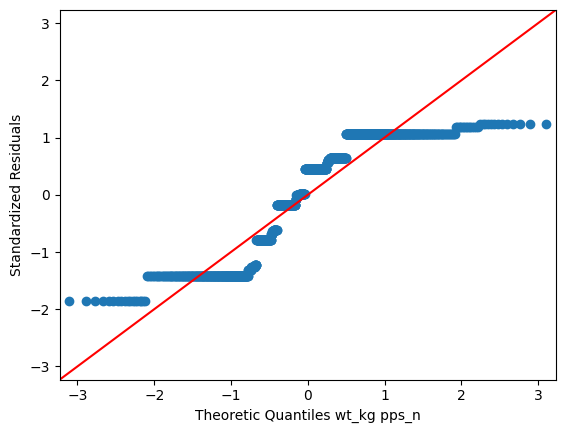

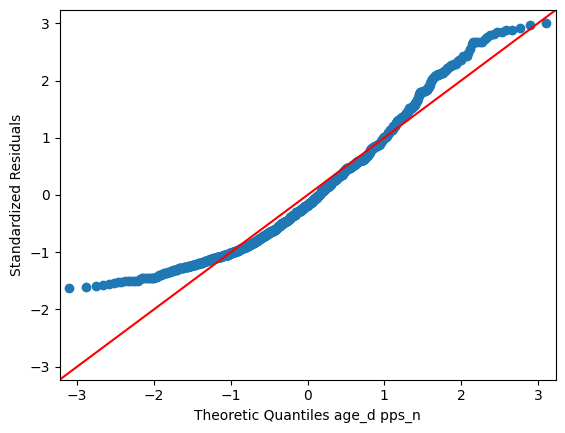

,group1,group2,Diff,Lower,Upper,q-value,p-value,df_num,dv_num,iv,ds_name,dv_name
0,1.0,0.0,0.765246,0.449515,1.080978,6.725907,0.001000,1,1,male_n,df,wt_kg
1,27.0,62.0,1.304292,-0.826706,3.435289,3.546984,0.900000,1,1,breed_n,df,wt_kg
2,27.0,53.0,0.074300,-1.886981,2.035581,0.219541,0.900000,1,1,breed_n,df,wt_kg
3,27.0,35.0,2.099081,0.081192,4.116970,6.028364,0.027152,1,1,breed_n,df,wt_kg
4,27.0,61.0,2.365402,0.489293,4.241511,7.306584,0.001000,1,1,breed_n,df,wt_kg
...,...,...,...,...,...,...,...,...,...,...,...,...
9048,0.0,3.0,0.700112,0.334442,1.065783,6.967247,0.001000,1,3,country,df,pps_n
9049,0.0,2.0,0.171455,-0.454992,0.797902,0.995977,0.889898,1,3,country,df,pps_n
9050,1.0,3.0,0.963870,0.337736,1.590003,5.601889,0.001000,1,3,country,df,pps_n
9051,1.0,2.0,0.092302,-0.714397,0.899002,0.416374,0.900000,1,3,country,df,pps_n


In [14]:
# Set up affectional naming for stratified LOB
# lob_dict_in = {1:['lob_auto'], 2:['lob_hl'], 3:['lob_wfvc']}
lob_dict_in = {1:['df']}
lob_df = pd.DataFrame(lob_dict_in)
lob_df = lob_df.T.reset_index()
lob_df.rename(columns={0: 'ds_name', 'index': 'df_num'}, inplace = True)


# Set up affection Dict naming for DV
# dv_dict_in = {1:['sentiment'], 2:['count of calls']}
dv_dict_in = {1:['wt_kg'], 2:['age_d'], 3:['pps_n']}
dv_df = pd.DataFrame(dv_dict_in)
dv_df = dv_df.T.reset_index()
dv_df.rename(columns={0: 'dv_name', 'index':'dv_num'}, inplace=True)


# Set up Dict for Model ID to b merge from above dict
# lob_ds = {1:lob_auto, 2:lob_hl, 3:lob_wfvc}
lob_ds = {1:df}


res = stat()
data_dict = {}
mt_data = pd.DataFrame()



# Set up dict for Full DVs
dvs = {1:'wt_kg', 2:'age_d', 3:'pps_n'}

# Created new list with pps removed as IV for use as a DV
# for i in cat:
for i in cat_nopps:
    for k1,v1 in dvs.items():
        for k, v in lob_ds.items():
            anova_df = df.loc[:,[v1,i]].dropna()
            # res.tukey_hsd(df=v, res_var=v1, xfac_var=i, anova_model=v1 + ' ~ C(' + i + ')')
            res.tukey_hsd(df=anova_df, res_var=v1, xfac_var=i, anova_model=v1 + ' ~ C(' + i + ')')
            sm.qqplot(res.anova_std_residuals,line='45')
            plt.xlabel('Theoretic Quantiles '+ v1+' ' +i)
            plt.ylabel("Standardized Residuals")
            plt.show()
            tmp = res.tukey_summary
            tmp['df_num'] = k
            tmp['dv_num'] = k1
            tmp['iv'] = i
            data_dict[k] = tmp
            mt_data = mt_data.append(data_dict[k])




# Get PPN as Sole IV
# Had to remove pps_n as a DV since it was an IV with dropna analysis
dvs = {1:'wt_kg', 2:'age_d'}
# for i in cat:
cat_pps_n = ['pps_n']
for i in cat_pps_n:
    for k1,v1 in dvs.items():
        for k, v in lob_ds.items():
            anova_df = df.loc[:,[v1,i]].dropna()
            sm.qqplot(res.anova_std_residuals,line='45')
            plt.xlabel('Theoretic Quantiles '+ v1+' ' +i)
            plt.ylabel("Standardized Residuals")
            plt.show()
            res.tukey_hsd(df=anova_df, res_var=v1, xfac_var=i, anova_model=v1 + ' ~ C(' + i + ')')
            tmp = res.tukey_summary
            tmp['df_num'] = k
            tmp['dv_num'] = k1
            tmp['iv'] = i
            data_dict[k] = tmp
            mt_data = mt_data.append(data_dict[k])



diffs = pd.merge(mt_data, lob_df, on=["df_num"])
diffs = pd.merge(diffs, dv_df, on=["dv_num"])
diffs





In [28]:
f = open('exp1.html','w')
a = cross_tmp.to_html()
f.write("Print A")
f.write(a)
f.write("Print B")
b = cross_tmp1.to_html()
f.write(b)
f.close()

In [29]:
os.getcwd()

'u:\\Fox\\Weisse\\EHPSS'

In [38]:
# import pdfkit

# https://stackoverflow.com/questions/56991534/excels-tdist-in-scipy
from scipy import stats

stats.t.sf(.66929, df=9999999999999) * 2


0.5033105045588153

AttributeError: module 'pandas' has no attribute 'tools'

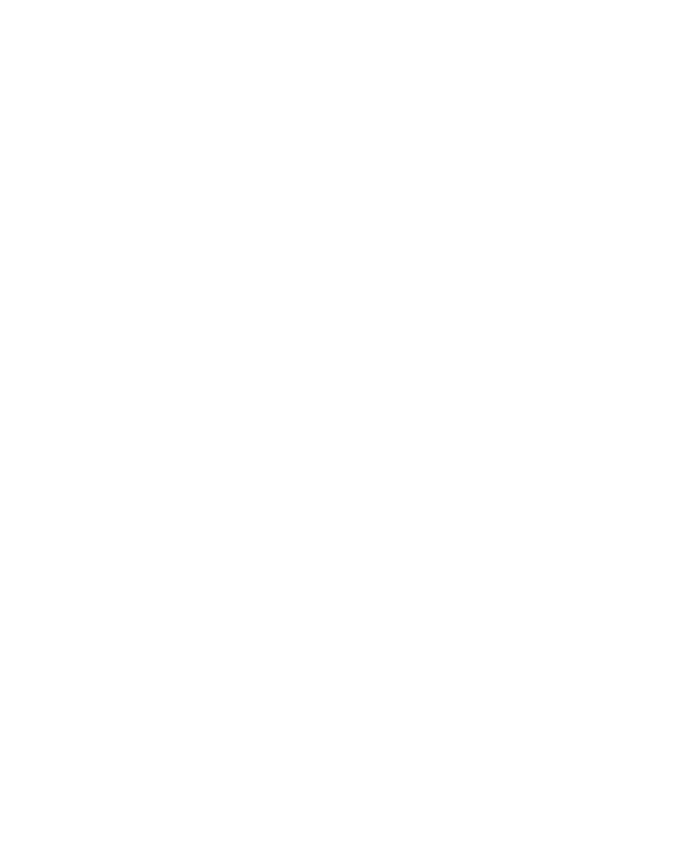

In [20]:
# crosstab = pd.crosstab(df['male_n'], df['breed_n'])
# # Normalize the cross tab to sum to 1:
# crosstab_normalized = crosstab.div(crosstab.sum(1).astype(float), axis=0)
# crosstab_normalized.plot(kind='bar', stacked=True, 
# title='Default by ' + str('male_n') + ' class')
# plt.savefig("class.pdf") #outputs blank file


# cross_tmp = chi_contingency(df,'pps_n','male_n',"1","chi_cont")
# cross_cat = cross_cat.append(cross_tmp)
def fn_print_pdf(df,pp): 
 total_rows, total_cols = df.shape

 rows_per_page = 30 # Number of rows per page
 rows_printed = 0
 page_number = 1
 while (total_rows >0):
    fig=plt.figure(figsize=(8.5, 11))
    plt.gca().axis('off')
    matplotlib_tab = pd.tools.plotting.table(plt.gca(),df.iloc[rows_printed:rows_printed+rows_per_page],
        loc='upper center', colWidths=[0.15]*total_cols)
    #Tabular styling
    table_props=matplotlib_tab.properties()
    table_cells=table_props['child_artists']
    for cell in table_cells:
        cell.set_height(0.024)
        cell.set_fontsize(12)
    # Header,Footer and Page Number
    fig.text(4.25/8.5, 10.5/11., "Sample", ha='center', fontsize=12)
    fig.text(4.25/8.5, 0.5/11., 'P'+str(page_number), ha='center', fontsize=12)
    pp.savefig()
    plt.close()
    #Update variables
    rows_printed += rows_per_page;
    total_rows -= rows_per_page;
    page_number+=1;

from scipy.stats import chisquare
from scipy.stats import chi2_contingency



cross_tmp1 = pd.crosstab(df['pps_n'].fillna('.'),df['shunt_ty'].fillna('.'))
# con = chi2_contingency(df,correction=False)
cross_tmp1

pp = PdfPages('Sample.pdf')
fn_print_pdf(cross_tmp,pp)
fn_print_pdf(cross_tmp1,pp)   
pp.close()
# crosstab_normalized = cross_tmp.div(cross_tmp.sum(1).astype(float), axis=0)
# crosstab_normalized.plot(kind='bar', stacked=True, 
# title='Default by ' + str('male_n') + ' class')
# plt.savefig("class.pdf") #outputs blank file


# ANOVA of continuous vars with top 5 Breed IV

In [11]:

res = stat()
data_dict = {}
t5_breed_data = pd.DataFrame()

dvs = {1:'wt_kg', 2:'age_d', 3:'pps_n'}

cat_breed = ['breed_n']
ds_breed = {1:breed_t5}

for i in cat_breed:
    for k1,v1 in dvs.items():
        for k, v in ds_breed.items():
            res.tukey_hsd(df=v, res_var=v1, xfac_var=i, anova_model=v1 + ' ~ C(' + i + ')')
            tmp = res.tukey_summary
            tmp['df_num'] = k
            tmp['dv_num'] = k1
            tmp['iv'] = i
            data_dict[k] = tmp
            t5_breed_data = t5_breed_data.append(data_dict[k])


breed_diffs = pd.merge(t5_breed_data, lob_df, on=["df_num"])
breed_diffs = pd.merge(breed_diffs, dv_df, on=["dv_num"])
breed_diffs

,group1,group2,Diff,Lower,Upper,q-value,p-value,df_num,dv_num,iv,ds_name,dv_name
0,53.0,35.0,2.313294,1.210279,3.416308,8.154610,0.001000,1,1,breed_n,df,wt_kg
1,53.0,61.0,2.537859,1.485706,3.590011,9.378696,0.001000,1,1,breed_n,df,wt_kg
2,53.0,38.0,0.134324,-1.088564,1.357212,0.427092,0.900000,1,1,breed_n,df,wt_kg
3,53.0,47.0,1.870511,0.539199,3.201822,5.463036,0.001360,1,1,breed_n,df,wt_kg
4,35.0,61.0,0.224565,-0.685496,1.134626,0.959457,0.900000,1,1,breed_n,df,wt_kg
5,35.0,38.0,2.447618,1.344603,3.550633,8.628117,0.001000,1,1,breed_n,df,wt_kg
6,35.0,47.0,4.183804,2.961684,5.405924,13.311015,0.001000,1,1,breed_n,df,wt_kg
7,61.0,38.0,2.672183,1.620031,3.724336,9.875093,0.001000,1,1,breed_n,df,wt_kg
8,61.0,47.0,4.408369,3.231951,5.584788,14.570341,0.001000,1,1,breed_n,df,wt_kg
9,38.0,47.0,1.736186,0.404874,3.067498,5.070727,0.003727,1,1,breed_n,df,wt_kg


In [13]:
my_sheets = ['cat_one' 'cross_cat' 'm_desc' 'm_class' 'diffs' 'breed_diffs']

writer = pd.ExcelWriter('ephss_out_20221219a.xlsx', engine = 'xlsxwriter')
# for i in my_sheets:
#     [i].to_excel(writer,sheet_name=i)
cat_one.to_excel(writer,sheet_name='cat_one')
cross_cat.to_excel(writer,sheet_name='cross_cat')
m_desc.to_excel(writer,sheet_name='m_desc')
m_class.to_excel(writer,sheet_name='m_class')
dt_diffs.to_excel(writer,sheet_name='dt_diffs')
breed_diffs.to_excel(writer,sheet_name='breed_diffs')
writer.save()


In [4]:
my_sheets = ['df']

writer = pd.ExcelWriter('df.xlsx', engine = 'xlsxwriter')
# for i in my_sheets:
#     [i].to_excel(writer,sheet_name=i)
df.to_excel(writer,sheet_name='data')
writer.save()


# Overall F Test

In [8]:

#Init Dict for DF to fill
data_dict = {}
mt_data  = pd.DataFrame()


# Set up affectional naming for stratified LOB
# lob_dict_in = {1:['lob_auto'], 2:['lob_hl'], 3:['lob_wfvc']}
lob_dict_in = {1:['df']}
lob_df = pd.DataFrame(lob_dict_in)
lob_df = lob_df.T.reset_index()
lob_df.rename(columns={0: 'ds_name', 'index': 'df_num'}, inplace = True)

# Python - Post-Hoc test for one-way ANOVA
# https://www.youtube.com/watch?v=BOGCsSzQNR4


# Set up affection Dict naming for DV
# dv_dict_in = {1:['sentiment'], 2:['count of calls']}
dv_dict_in = {1:['wt_kg'], 2:['age_d'], 3:['pps_n']}
dv_df = pd.DataFrame(dv_dict_in)
dv_df = dv_df.T.reset_index()
dv_df.rename(columns={0: 'dv_name', 'index':'dv_num'}, inplace=True)


# Set up Dict for Model ID to b merge from above dict
# lob_ds = {1:lob_auto, 2:lob_hl, 3:lob_wfvc}
lob_ds = {1:df}
# Set up dict for DVs
dvs = {1:'wt_kg', 2:'age_d', 3:'pps_n'}

for i in cat:
    for k1,v1 in dvs.items():
        for k,v in lob_ds.items():
            model = ols(v1 + ' ~ C(' + i + ')', data =v).fit()
            tmp = sm.stats.anova_lm(model, type=2) #typ = 2 also works
            tmp['df_num'] = k
            tmp['dv_num'] = k1
            tmp['iv'] = i
            data_dict[k] = tmp
            mt_data = mt_data.append(data_dict[k])


df_ftest = pd.merge(mt_data, lob_df, on=["df_num"])
df_ftest = pd.merge(df_ftest, dv_df, on=["dv_num"])
df_ftest



,df,sum_sq,mean_sq,F,PR(>F),df_num,dv_num,iv,ds_name,dv_name
0,1.0,1.428432e+02,1.428432e+02,2.108325e+01,4.921757e-06,1,1,male_n,df,wt_kg
1,1065.0,7.215583e+03,6.775195e+00,NaN,NaN,1,1,male_n,df,wt_kg
2,62.0,3.541848e+03,5.712658e+01,1.495010e+01,2.129818e-103,1,1,breed_n,df,wt_kg
3,990.0,3.782940e+03,3.821152e+00,NaN,NaN,1,1,breed_n,df,wt_kg
4,43.0,5.142936e+02,1.196032e+01,1.787722e+00,1.563244e-03,1,1,shunt_ty,df,wt_kg
5,1023.0,6.844132e+03,6.690256e+00,NaN,NaN,1,1,shunt_ty,df,wt_kg
6,8.0,1.937846e+02,2.422308e+01,3.577013e+00,4.177852e-04,1,1,portal_v,df,wt_kg
7,1058.0,7.164641e+03,6.771873e+00,NaN,NaN,1,1,portal_v,df,wt_kg
8,8.0,1.840302e+02,2.300377e+01,3.392340e+00,7.438002e-04,1,1,system_v,df,wt_kg
9,1058.0,7.174396e+03,6.781092e+00,NaN,NaN,1,1,system_v,df,wt_kg


In [ ]:
# my_list = cont.copy()
# my_list += ['male_c']



# print(cont)
# print(type(cont))
# my_list = cont.copy()
# print(my_list)
# print(type(my_list))
# my_list += ['male_c']
# print(my_list)


# my_df = df[df.columns[df.columns.isin(my_list)]]

# print(my_df)
# my_df1 = df['wt_kg'].groupby(['male_c']).describe()
# df_2 = pd.DataFrame(df['wt_kg'].describe().tolist(), columns = ['Test2'])
# df_2 = pd.DataFrame(df['wt_kg'].groupby([male_c']).describe(), columns = ['Test2'])
# tmp = df.groupby(['male_c']).mean().reset_index()
# print(tmp)

# ds_counts = df["ds_size"].unique().tolist()
# dt_counts = df["month_year"].unique().tolist()

# blank_df = pd.DataFrame()
# for j in dt_counts:
#     for i in ds_counts:
#         tmp_prec = df.copy()
#         tp_prec = tmp_prec[['tot', 'recall', 'month_year']]
#         tmp_makse = (tmp_prec['tot'] == 1) & (tmp_prec['month_year'] == j)
#         tmp = tmp_prec.loc[tmp_mask]
#         tmp_df = tmp.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
#         tmp_df = tmp_df.T
#         tmp_df['ds_size'] = i
#         tmp_df['dt'] = j
#         blank_df = blank_df.append(tmp_df)

# print(blank_df.head(5))
# print(blank_df.tail(5))
# print(len(blank_df))


In [ ]:
# aov1 = aov(npl,"age_d","male_c",1)
# aov1 = aov(npl,"wt_kg","male_c",1)
# aov1 = aov(npl,"pps_n","male_c",1)
# aov1


def aovme(iv):
    # blank_aov = pd.DataFrame()
    for i in cont:
        tmp = df.copy()
        tmp_df = aov(tmp,i,iv,1)        
        tmp_df['dv'] = i
        tmp_df['iv'] = iv
        print(tmp_df)
        blank_aov = blank_aov.append(tmp_df)        
    return blank_aov
        


# cat = ['male_n', 'breed_c', 'shunt_ty', 'portal_v', 'system_v', 'contrb_v', 'hospital', 'country', 'pps_c']
# my_aov = aovme('male_c')
# my_aov = aovme('shunt_ty') # Too many levels for ANOVA
# aovme('breed') # Too many levels for ANOVA
# my_aov = aovme('portal_v') # Too many levels for ANOVA
# my_aov = aovme('system_v') # Too many levels for ANOVA
my_aov = aovme('contrb_v') # Too many levels for ANOVA


# print(blank_aov.head(5))
# print(blank_aov.tail(5))
# print(len(blank_aov))
# breed_c shunt_ty portal_v sysem_v contrb_v hospital country pps_c

: 

In [63]:
# s = sorted([str(round(i * 100, 1)) for i in npl['age_d']])
s = sorted([str(round(i * .01, 2)) for i in npl['age_d']])


s = (
    pd.Series(s)
    .groupby([str(int(float() )) for i in s])
    .apply(lambda group: "".join((x[-1] for x in group)))
    .reset_index()
)

print("\n".join(s['index'] + ' | ' + s[0]))

stemme = ("\n".join(s['index'] + ' | ' + s[0]))

stemmedf = pd.DataFrame([x.split(';') for x in stemme.split('\n')])

0 | 500000000000045688889999991111111122222222222223333333333333334444444444445555555555555555555556666666666777777777777788888888888888888889999999999222222222211111111111111222222222222222223333333444444444555555555555555666666666666667777777777788888888888888888999999993333333333333111111111222222222222222333333334444555555556666666666677777777777788888899999999994444444444444441112222222223333444444445555555555666666666777788889999955551111112223333334444555566666777788888899966661111122222233333344444555555666667777888997777777111112233333333333333444444555555666667777888999998811223335555588888889999999111222334444444455566778000111122333344566888888999991111111111111111112222233444445566789999221234555666667788899311111222223345778894442234555555666666667788899555555112223345699612222333344456667887445667777898112233333345556667788999913334455567788889001122233344588223334467799992222111222334455777788999112233567778899444235667236666788866661122333445697125667889882456899999222

In [9]:
# ds_counts = npl["ds_size"].unique().tolist()
# dt_counts = npl["month_year"].unique().tolist()
# blank_df = pd.DatFrame()
# for j in dt_counts:
#     for i in ds_counts:
#         tmp_prec = npl.copy()
#         tmp_prec = tmp_prec[['tot', 'recall', "month_year']]
#         tmp_mask = tmp_prec['tot'] == i) & (tmp_prec['monthy_year'] == j)
#         tmp = tmp_prec.loc[tmp_mask]
#         tmp_df = tmp.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
#         tmp_df = tmp_df.T
#         tmp_df['ds_size'] = i
#         tmp['dt'] = j
# 
#         blank_df = blank_df.append(tmp_df)

#         print(blank_df.head(5))
#         print(blank_df.tail(5))
#         print(len(blank_df))



blank_df = pd.DataFrame()

for i in cont:
    tmp = npl.copy()
    tmp_df = means_desc(npl,i)
    tmp_df = tmp_df.T
    tmp_df['iv'] = i
    blank_df = blank_df.append(tmp_df)

    print(blank_df.head(5))
    print(blank_df.tail(5))
    print(len(blank_df))


                  0     iv
ds            age_d  age_d
nmiss             0  age_d
n            1082.0  age_d
mean    1426.200739  age_d
median        722.5  age_d
               0     iv
std  3669.004669  age_d
min       -548.0  age_d
max      41319.0  age_d
p25        298.0  age_d
p75       1682.5  age_d
10


KeyError: "['mean', 'median', 'std', 'min', 'max', 'p25', 'p75'] not in index"

In [ ]:
import saspy, os, pandas as pd
print(saspy.__file__.replace('__init__.py', 'sascfg_personal.py'))
#  {SAS004}80898A647C57DF69657904C24EDA7E237590869733B342AC
# sas = saspy.SASsession()
sas = saspy.SASsession(cfgname='oda')
sas
hr = sas.df2sd(df)  # the short form of: hr = sas.dataframe2sasdata(hr_pd)
hr.columnInfo()
# hr.head()
# hr.means()
# hr.bar('age_d')
# hr.hist('wt_kg')
# hr.heatmap('age_d', 'male_c')
c = sas.submitLST("""
proc sgpanel data=work._df;
    PANELBY pps_n;
    hbar male_n / response=wt_kg    stat=median;
    hbar male_n / response=age_d stat=median;
run;
""")

In [ ]:
# Cntrl 1 Comment Out
# edj.rename(columns = {'SYMBOL/CUSIP':'ticker','SHARES':'vol'}, inplace = True) 
# print(type(df))
# print(df.head(2))
# df.info()
# for i in df.columns:
#     print(i)


# npl['sex'] = npl['GENDER'].astype(int)
# npl.info()
# npl = npl.astype({'wt_kgs': 'float64'})
# npl['wt'] = npl['wt_kgs'].apply(lambda x: float(x.split()[0].replace('', 'NaN')))
# npl['pps_n'].describe()
# npl = npl.astype({'wt': 'float64'})
# npl.describe()

# all_df = all_df.astype({'recall': 'float64', 'ds_size': 'float64'})
# all_df.info()

# all_df['monht_year'] = pd.to_datetime(all_df['dt']).dt.to_period("M")

# all_df['condition'] = ""

# all_df.loc[(all_df['tp'] ==1), "condtion"] = 'tp'

# all_df['gt'] = all_df.xxx.apply(lambda x: 1 if x == "Y" else 0)
# all_df = all_df[all_df.coumns[~all_df.columns.isin(['xxx'])]]


# month_data = []
# gridvars = ['tp', 'tn', 'fn', 'fp']
# for i in time_mo:
#     my_mo = df.loc[(df[month_year] == i)]
#     print(my_mo)
#     print(len(my_mo))
#     df_in = my_modfs = df_in[gridvars].sum
#     dfs = dfs.to_frame()
#     dft = dfs.transpose()
#     dft['tot'] = dft.sum(axis=1)
#     dft['tpfn'] = dft.loc[:,['tp','fn']].sum(axis=1)
#     dft['tpfp'] = dft.loc[:,['tp','fp']].sum(axis=1)
#     dft['fpfn'] = dft.loc[:,['fp','fn']].sum(axis=1)
#     dft['recall'] = dft.tp / dft.tpfn
#     dft['precision'] = dft.tp / dft.tpfn
#     dft['recall'] = dft.tp / dft.tpfp
#     dft['pct_gtc'] = dft.tpfn / dft.tot
#     dft['pct_nsc'] = dft.fpfn / dft.tot
#     dft['month_id'] = i
#     month_data.append(dft)


# month_df.rename(column={0:'tp', 1: 'tn'}, inplace = True)

# df.loc[(df['gt'] == 1) & (df['mod'] == 1), 'tp'] = 1
# df.loc[(df['gt'] == 0) & (df['mod'] == 0), 'tn'] = 1

# df['condition'] = ""
# df.loc[(df['Price'] <=100) & (df['Category']=='A'), "Flag"] = 'X'
# df.loc[(df['tp'] ==1), "condition"] = 'tp'
# df.loc[(df['tn'] ==1), "condition"] = 'tn'


# def pef_c(row):
#     if  row['date'] < '2020-03-01':
#         val = 'pre'
#     elif row['date'] >= '2020-03-01' and row['date'] < '2022-03-01':
#         val = 'during'
#     elif row['date'] >= '2022-03-01':
#         val = 'post'
#     else:
#         val = 'error'
#     return val



# def checkAge(inpAge, minAge):
#     if(inpAge>=minAge):
#         return 'senior'
#     else:
#         return 'fresher'
    
# npl['age_ty']=npl['AGE_DAYS'].apply(checkAge, args=(25,))

 
# Priting data
# print(npl.male_n)
# print(npl.male_c)

# npl['sex'] = npl['GENDER'].astype(str)


# npl['male_c'] = (dataFrame.loc[(dataFrame['Salary']>=100000) & (dataFrame['Age']< 40) & (dataFrame['JOB'].str.startswith('D')),
#                     ['Name','JOB']])
# ['sex'] = npl['GENDER'].astype(int)

# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# aov1 = ols('age_d ~ C(gender)',data=df).fit()
# table = sm.stats.anova_lm(aov1, typ=2) # Type 2 Anova DataFrame
# print(table)

from saspy import SASsession
sas = SASsession(results='HTML')
print(type(sas))